In [12]:
import backtrader as bt
import pandas as pd
from numpy import *
%matplotlib inline
import backtrader.analyzers as btanalyzers

df = pd.read_csv('BTCUSDT3.csv',index_col=0)
df.columns = ['open_time','open','high','low','close','volume','close_time']
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df = df.set_index('open_time')
df.head()

,open,high,low,close,volume,close_time
open_time,,,,,,
2021-11-10 00:00:00,66947.67,66984.51,66944.76,66976.54,20.07992,2021-11-10 00:00:59.999
2021-11-10 00:01:00,66972.71,67000.00,66972.71,66996.67,17.94288,2021-11-10 00:01:59.999
2021-11-10 00:02:00,66996.67,67121.11,66996.67,67029.95,132.40448,2021-11-10 00:02:59.999
2021-11-10 00:03:00,67029.94,67113.22,67025.85,67102.72,51.82755,2021-11-10 00:03:59.999
2021-11-10 00:04:00,67102.71,67144.25,67060.81,67078.76,30.35043,2021-11-10 00:04:59.999


In [13]:
feeds = bt.feeds.PandasDirectData(
    name='BTC', # 多股回测时用户区分数据对象
    timeframe = bt.TimeFrame.Minutes,
    dataname=df,
#     datetime=0,  # 日期行所在列
    dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
    tmformat=('%H:%M:%S'), # 时间格式
    open=1,  # 开盘价所在列
    high=2,  # 最高价所在列
    low=3,  # 最低价所在列
    close=4,  # 收盘价价所在列
    volume=5,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
)

In [14]:
# 创建一个策略
pnl = pd.DataFrame()
value_lis = []
date_lis = []
class R_Breaker(bt.Strategy):
    # 需要调优的参数
    params = (
        ('stop_loss', 2),
        )
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.close_p = self.datas[0].close
        self.high = self.datas[0].high
        self.low  = self.datas[0].low
        self.open = self.datas[0].open
        self.stop_loss = self.params.stop_loss/100
        
        self.high_lis = []
        self.low_lis = []
        self.close_p_lis = []
        
        self.day_counter = 0
        self.start_strategy = False
        self.single_day_high_lis = []
        self.single_day_low_lis = []
        
        
    def next(self):
        date = self.datas[0].datetime.datetime(0)
        day = str(date).split(' ')[0]
        time = str(date).split(' ')[1]
        size = self.getposition(data = self.datas[0]).size
        
        self.single_day_high_lis.append(self.high[0])
        self.single_day_low_lis.append(self.low[0])
        
#         self.log(size)
        
        if time == '00:00:00':
            self.day_counter += 1
            self.close_p_lis.append(self.close_p[0])
            self.high_lis.append(max(self.single_day_high_lis))
            self.low_lis.append(min(self.single_day_low_lis))
            self.single_day_high_lis = []
            self.single_day_low_lis = []
            
            if self.day_counter == 1:
                # 计算各个指标
                high = self.high_lis[0]
                close = self.close_p_lis[0]
                low = self.low_lis[0]
                
                pivot = (high + low + close) / 3  # 枢轴点
                self.bBreak = high + 2 * (pivot - low)  # 突破买入价
                self.sSetup = pivot + (high - low)  # 观察卖出价
                self.sEnter = 2 * pivot - low  # 反转卖出价
                self.bEnter = 2 * pivot - high  # 反转买入价
                self.bSetup = pivot - (high - low)  # 观察买入价
                self.sBreak = low - 2 * (high - pivot)  # 突破卖出价

                self.high_lis.remove(self.high_lis[0])
                self.low_lis.remove(self.low_lis[0])
                self.close_p_lis.remove(self.close_p_lis[0])
                self.start_strategy = True
                self.day_counter -= 1
                self.log('收盘平仓')
                self.close()
        
        if self.start_strategy:
            # 空仓条件
            if size == 0:
                # 盘中价格突破买入价
                if self.close_p[0] > self.bBreak: 
                    self.order_target_percent(target=0.9)
                    self.log('-'*50+'开仓做多'+'-'*50)
                    
                    # 记录开仓价格
                    try:
                        self.open_price = self.open[1]
                    except IndexError:
                        print('回测结束')
                    except:
                        print("something else error")
                    
                elif self.close_p[0] < self.sBreak:
                    self.order_target_percent(target=-0.9)
                    self.log('-'*50+'开仓做空'+'-'*50)
                    
                    # 记录开仓价格
                    try:
                        self.open_price = self.open[1]
                    except IndexError:
                        print('回测结束')
                    except:
                        print("something else error")
                
            # 有仓位
            else:
                unrealized_pnl = self.close_p[0]/self.open_price - 1
                
                if (size > 0 and unrealized_pnl <= -self.stop_loss) or (size < 0 and unrealized_pnl >= self.stop_loss) : 
                    self.close()
                    self.log('止损平仓')
                    unrealized_pnl=0
                    
                if size > 0:
                    if self.high[0] > self.sSetup and self.close_p[0] < self.sEnter:
                        self.close()
                        self.log('反转平仓')
                        self.order_target_percent(target=-0.9)
                        self.log('-'*50+'反手做空'+'-'*50)
                        # 记录开仓价格
                        try:
                            self.open_price = self.open[1]
                        except IndexError:
                            print('回测结束')
                        except:
                            print("something else error")
                
                elif size < 0:
                    if self.high[0] < self.bSetup and self.close_p[0] > self.bEnter:
                        self.close()
                        self.log('反转平仓')
                        self.order_target_percent(target=0.9)
                        self.log('-'*50+'反手做多'+'-'*50)
                        # 记录开仓价格
                        try:
                            self.open_price = self.open[1]
                        except IndexError:
                            print('回测结束')
                        except:
                            print("something else error")

        # 获取当天value
        value = self.broker.getvalue()
        date_lis.append(date)
        value_lis.append(value)
        

In [15]:
pnl = pd.DataFrame()
value_lis = []
date_lis = []

class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
cerebro.adddata(feeds)
cerebro.addstrategy(R_Breaker)
cerebro.broker.setcommission(commission=0.0004)
commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe",timeframe=bt.TimeFrame.Minutes, annualize=True, riskfreerate=0.02)
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns",timeframe=bt.TimeFrame.Minutes)

thestrats = cerebro.run()
thestrat = thestrats[0]
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00000
2021-11-10, 收盘平仓
2021-11-10, --------------------------------------------------开仓做多--------------------------------------------------
2021-11-10, 反转平仓
2021-11-10, --------------------------------------------------反手做空--------------------------------------------------
2021-11-10, 止损平仓
2021-11-10, --------------------------------------------------开仓做多--------------------------------------------------
2021-11-10, 止损平仓
2021-11-10, --------------------------------------------------开仓做多--------------------------------------------------
2021-11-10, 反转平仓
2021-11-10, --------------------------------------------------反手做空--------------------------------------------------
2021-11-11, 收盘平仓
2021-11-12, 收盘平仓
2021-11-12, --------------------------------------------------开仓做空--------------------------------------------------
2021-11-12, 止损平仓
2021-11-13, 收盘平仓
2021-11-14, 收盘平仓
2021-11-15, 收盘平仓
2021-11-16, 收盘平仓
2021-11-16, --------------------------------------------

2022-05-28, 收盘平仓
2022-05-29, 收盘平仓
2022-05-30, 收盘平仓
2022-05-30, --------------------------------------------------开仓做多--------------------------------------------------
2022-05-31, 收盘平仓
2022-06-01, 收盘平仓
2022-06-01, --------------------------------------------------开仓做空--------------------------------------------------
2022-06-02, 收盘平仓
2022-06-03, 收盘平仓
2022-06-04, 收盘平仓
2022-06-05, 收盘平仓
2022-06-06, 收盘平仓
2022-06-06, --------------------------------------------------开仓做多--------------------------------------------------
2022-06-07, 收盘平仓
2022-06-08, 收盘平仓
2022-06-09, 收盘平仓
2022-06-10, 收盘平仓
2022-06-10, --------------------------------------------------开仓做空--------------------------------------------------
2022-06-11, 收盘平仓
2022-06-12, 收盘平仓
2022-06-13, 收盘平仓
2022-06-13, --------------------------------------------------开仓做空--------------------------------------------------
2022-06-14, 收盘平仓
2022-06-15, 收盘平仓
2022-06-16, 收盘平仓
2022-06-17, 收盘平仓
2022-06-18, 收盘平仓
2022-06-18, -----------------------------

<IPython.core.display.Javascript object>


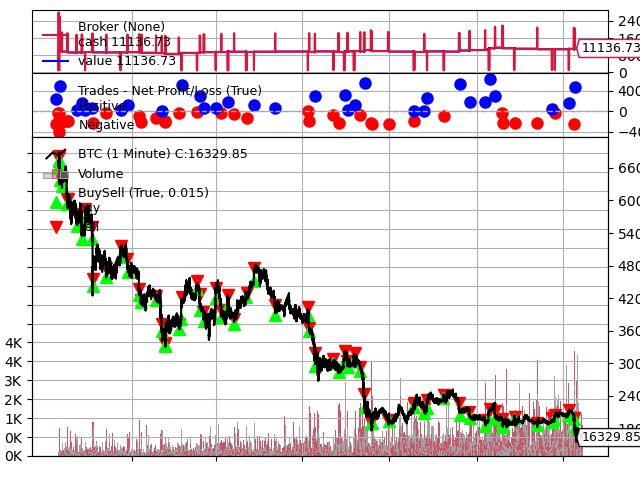

[[<Figure size 640x480 with 4 Axes>]]

In [16]:
cerebro.plot()

<IPython.core.display.Javascript object>


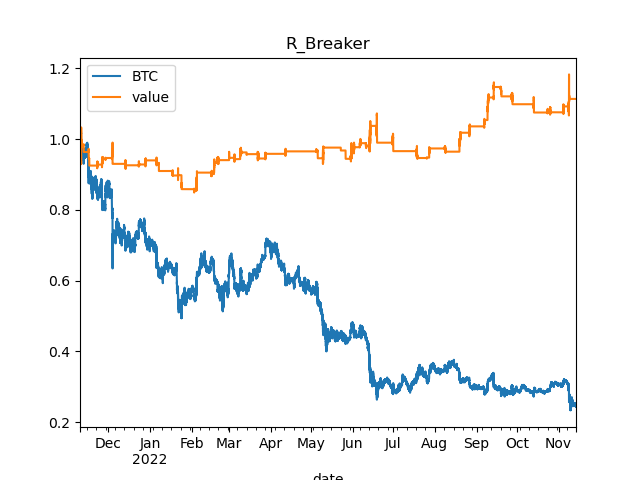

In [17]:
import numpy as np
pnl = pd.DataFrame()
pnl['date'] = date_lis
pnl['BTC'] = np.array(df['close']/df['close'][0])
pnl['value'] = np.array(value_lis)/value_lis[0]

pnl = pnl.set_index('date')
pnl.plot(title='R_Breaker')

<IPython.core.display.Javascript object>


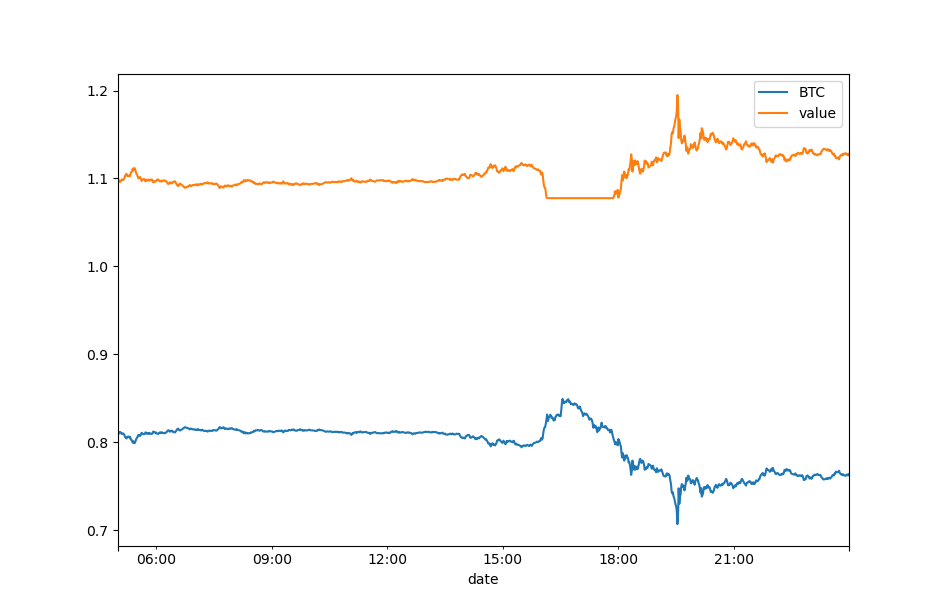

In [11]:
pnl['2022-11-08 05:00:00':'2022-11-08'].plot()

# 参数调优

In [ ]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)
print('Starting Portfolio Value: %.5f' % cerebro.broker.getvalue())
cerebro.adddata(feeds)
cerebro.broker.setcommission(commission=0.0004)

cerebro.optstrategy(
    strategy=R_Breaker,
    stop_loss=range(1,7),
)

commission = 0.001
comminfo = CommInfoFractional(commission=commission)
cerebro.broker.addcommissioninfo(comminfo)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe",timeframe=bt.TimeFrame.Minutes, annualize=False)
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns",timeframe=bt.TimeFrame.Minutes)
result = cerebro.run(maxcpus=1)
print('Final Portfolio Value: %.5f' % cerebro.broker.getvalue())

In [ ]:
par_list = [[x[0].params.stop_loss,
            x[0].analyzers.returns.get_analysis()['rtot'], 
            x[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            x[0].analyzers.sharpe.get_analysis()['sharperatio']
                ] for x in result]

par_df = pd.DataFrame(par_list, columns = ['stop_loss', 'return', 'max_drawdown', 'sharpe'])
par_df